# 파이썬 웹 크롤링 & 텍스트 분석

## 10. 다음 영화 리뷰 시각화하기
- 태그 추출하기
- 워드클라우드 그리기
    - reference: http://konlpy.org/ko/v0.4.3/examples/wordcloud/
- 네트워크 그래프 그리기

### 리뷰 데이터 불러오기
- ```open()``` 함수를 통해 파일을 열며, 열때 "r" (읽기) 모드로 설정한다.

In [3]:
file = open("4-4.txt", "r", encoding="utf-8")
data = file.read().split("\n")
file.close()

### 태그 추출하기 
- 워드클라우드에 들어갈 데이터를 처리하기 위해 태그를 추출하고 그 사이즈와 색을 설정하기 위한 함수를 정의한다
- 텍스트를 토큰화한 후 명사(noun)만 추출한다
- 각 명사의 발생 빈도에 따라 태그의 크기(size)를 설정한다
- 워드 클라우드에 들어갈 각 태그의 색(color)은 랜덤하게 설정한다

In [2]:
import random
from konlpy.tag import Twitter 			
from collections import Counter

In [5]:
def get_tags(text, ntags = 100, multiplier = 1):
    t = Twitter()
    nouns = []
    for sentence in text:
        for noun in t.nouns(sentence):
            nouns.append(noun)
    
    result = []
    count = Counter(nouns)
    
    for n, c in count.most_common(ntags):
        temp = {"color": (random.randint(0,255),random.randint(0,255),random.randint(0,255)),
                "tag": n,
                "size": c * multiplier}
        result.append(temp)
            
    return result

In [7]:
# get_tags() 함수로 태그 가져오기
tags = get_tags(data)
print(tags[0])
print(tags[1])
print(tags[2])

{'color': (143, 8, 160), 'tag': '영화', 'size': 621}
{'color': (49, 57, 85), 'tag': '음악', 'size': 183}
{'color': (49, 157, 124), 'tag': '너무', 'size': 123}


### 워드클라우드 그리기

In [8]:
import pytagcloud, webbrowser

def draw_cloud(tags, fname, fontname = "Noto Sans CJK", size = (1000, 600)):
    pytagcloud.create_tag_image(tags, fname, fontname = fontname, size = size)
    webbrowser.open(fname)

In [9]:
# 워드클라우드 그리고 파일 열기
draw_cloud(tags, "wordcloud.png")

### 실습10-1. 다음 영화 리뷰 시각화하기
- 자신이 크롤링한 다른 영화의 리뷰 데이터의 워드클라우드를 그려 시각화를 해본다

In [ ]:
## Your answer

### 네트워크 그래프 그리기

In [30]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from konlpy.tag import Twitter 	

In [18]:
file = open("4-4.txt", "r", encoding="utf-8")
data = file.read().split("\n")
file.close()

In [19]:
t = Twitter()
noun_counts = {}

In [20]:
for i in range(len(data)):
    review = t.nouns(data[i])
    for token in review:
        if token not in noun_counts.keys():
            noun_counts[token] = 1
        else:
            noun_counts[token] += 1
    data[i] = review


print(len(noun_counts))
print(len(data))

2041
959


In [21]:
unique_nouns = list(noun_counts.keys())
noun_idx = {noun: i for i, noun in enumerate(unique_nouns)}    
idx_noun = {i: noun for i, noun in enumerate(unique_nouns)}    

In [22]:
# 명사가 함께 등장하는 수를 세기 위한 빈도행렬(occurrence matrix)
occur_matrix = np.zeros([len(data), len(unique_nouns)])

In [23]:
# 빈도 행렬을 채워넣는다
# 특정 단어가 리뷰에 등장할 경우 1, 등장하지 않을 경우 0으로 인코딩(one-hot encoding)
for i, r in enumerate(data):
    for n in r:
        idx = noun_idx[n]
        occur_matrix[i][idx] = 1

In [24]:
# 빈도 행렬의 전치행렬과 빈도행렬을 곱해 공빈도 행렬(cooccurrence matrix)을 생성한다
co_occur_matrix = np.dot(occur_matrix.T, occur_matrix)

print(co_occur_matrix.shape)

(2041, 2041)


In [25]:
# 네트워크 그래프의 노드의 색을 정의 - 여기서는 랜덤하게 생성
color_map = {"a": "#ffd1df", \
            "b": "#d0fefe", \
            "c": "#ffff84", \
            "d": "#ffffd4", \
            "e": "#65fe08"}

In [26]:
# 그래프를 생성한다
G = nx.Graph()

In [27]:
# 노드를 생성한다
for n in noun_idx.keys():
    if noun_counts[n] > 5:
        G.add_node(n, group = np.random.choice(["a", "b", "c", "d", "e"]), nodesize = noun_counts[n])

In [28]:
# 링크를 생성한다
for i in range(len(co_occur_matrix)):
    for j in range(i+1, len(co_occur_matrix)):
        if co_occur_matrix[i][j] > 10:
            G.add_weighted_edges_from([(idx_noun[i], idx_noun[j], co_occur_matrix[i][j])])

In [61]:
# matplotlib figure를 생성
plt.figure(figsize = (15, 15))

In [62]:
# 그래프 시각화의 옵션을 설정
options = {
    "edge_color": "#3c4142",
    "width": 2,
    "width_labels": True,
    "font_weight": "regular",
    "font_size": 10,
}

In [63]:
colors = [color_map[G.node[node]["group"]] for node in G]
sizes = [G.node[node]["nodesize"] * 50 for node in G]
labels = {noun: i for i, noun in enumerate(G.nodes)}

In [64]:
# 그래프를 그린다
nx.draw(G, node_color=colors, node_size=sizes, labels = labels,\
        pos=nx.spring_layout(G, k=1.0, iterations=50), **options)

In [65]:
# 그래프 설정을 변경
# ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 

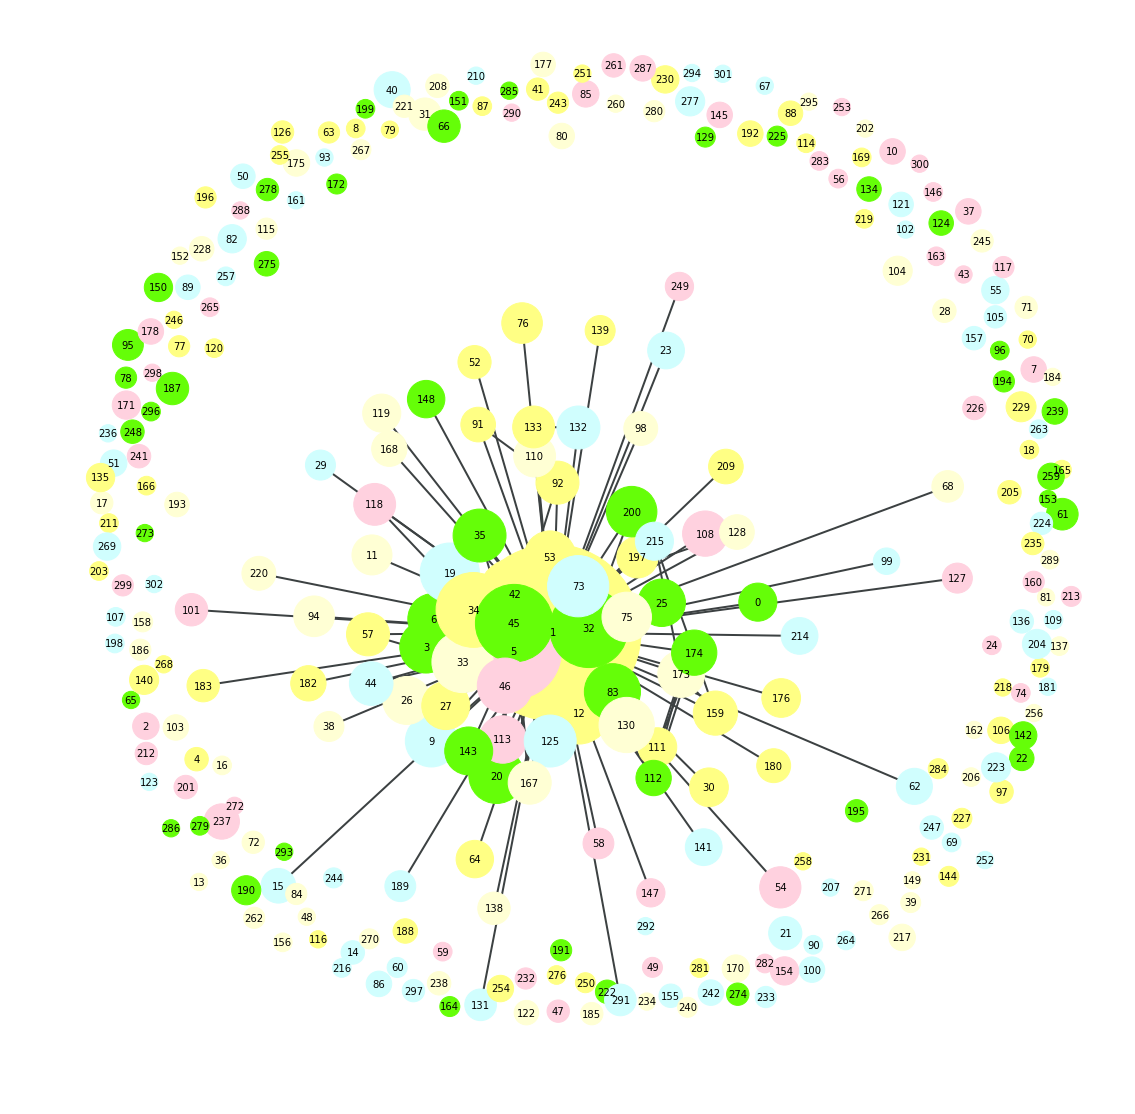

In [66]:
plt.show()

### 실습10-2. 다음 영화 리뷰 시각화하기
- 자신이 크롤링한 다른 영화의 리뷰 데이터의 네트워크 그래프를 그려 시각화를 해본다

In [ ]:
### Your answer